In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../..")

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HarshithBachimanchi/PlanktonReview/blob/main/notebooks/02.track_2D_holography.ipynb)

In [2]:
import random

import deeptrack as dt
import deeptrack.extras
import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

/opt/anaconda3/envs/tf-metal/lib/python3.8/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/opt/anaconda3/envs/tf-metal/lib/python3.8/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import analysis as an

In [29]:
# Load the data
frames = np.load("/Users/harshithbachimanchi/Documents/Courses/ScientificWriting/holography_videos/Frames_ps_600.npy")
positions = np.load("/Users/harshithbachimanchi/Documents/Courses/ScientificWriting/holography_videos/detections_220419_ps7.npy", allow_pickle=True)
frames = frames[2:]
positions = positions[2:]
print(np.shape(frames), np.shape(positions))

(598, 1024, 1280) (3598,)


In [33]:
# np.save("../data/frame_ps.npy", frames[0])
# np.save("../data/positions_ps.npy", positions[0])

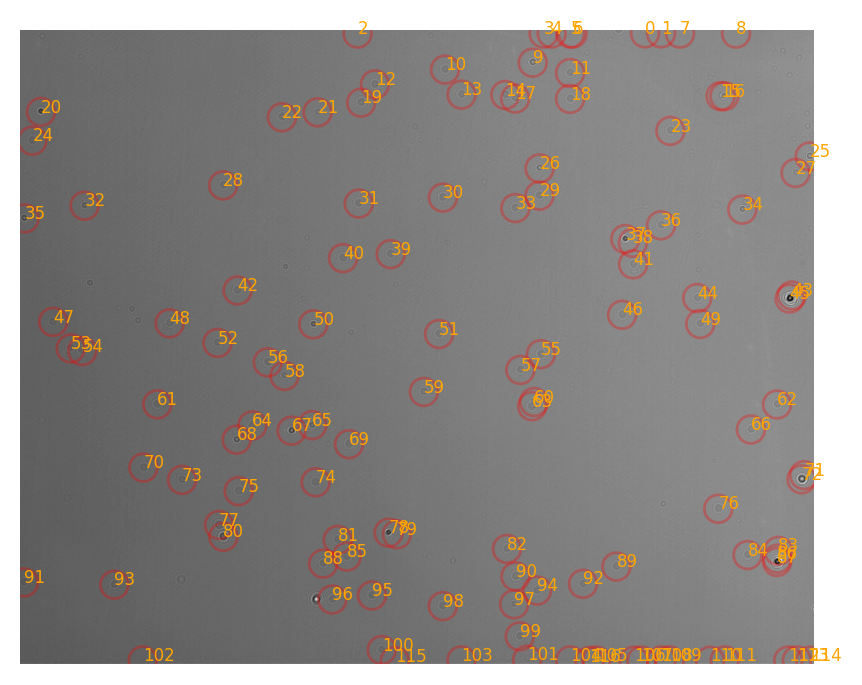

In [5]:
frame = frames[0]
dpi=200
plt.figure(figsize=(frame.shape[0]/dpi, frame.shape[1]/dpi), dpi=dpi, frameon=False)
plt.imshow(frame, cmap="gray")
plt.scatter(positions[0][:, 0], positions[0][:, 1], s=100, facecolors="None", edgecolors="red", alpha=0.3)
[plt.text(positions[0][:,0][i], positions[0][0:,1][i], str(i), color="orange", fontsize=6) for i in range(len(positions[0]))]
plt.axis("off")
plt.show()

In [6]:
plankton_numbers = [61, 59, 46]

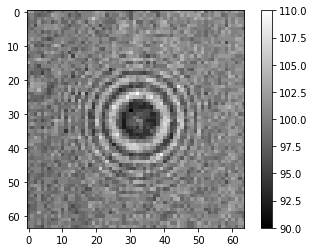

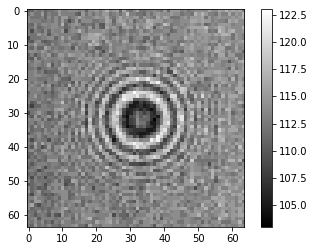

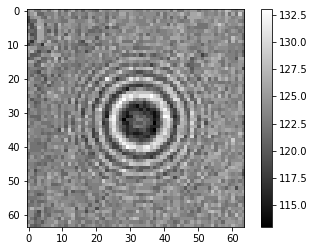

In [7]:
crop_width = 64
crops=[]
for plankton in plankton_numbers:
    pos = positions[0][:,0][plankton], positions[0][:,1][plankton]
    crop = frame[int(pos[1] - crop_width/2) :int(pos[1] + crop_width/2), int(pos[0] - crop_width/2) : int(pos[0] + crop_width/2)]
    crops.append(crop)
    plt.imshow(crop, cmap="gray")
    plt.colorbar()
    plt.show()
# crops = np.expand_dims(crops, axis=-1)

In [8]:
import scipy.fft as sp
import math
def reconstruction(z):
    def inner(image):
        wavelength = 0.625  # wavelength
        pi = math.pi
        k = 2 * pi * (1.33) / wavelength
        dx = 5.2  # Pixelsize of the camera
        # -------------------------------
        N1 = np.size(image, 0)
        N2 = np.size(image, 1)
        ky = 2 * pi / dx * (np.arange(-N1 / 2, (N1 / 2)) / N1)
        kx = 2 * pi / dx * (np.arange(-N2 / 2, (N2 / 2)) / N2)
        [KX, KY] = np.meshgrid(kx, ky)
        kz = np.sqrt(k ** 2 - (np.square(KX) + np.square(KY)))  # Planewave
        kz[kz.imag != 0] = 0
        T = np.exp(1j * kz * z)
        ImageFFT = sp.fftshift(sp.fft2(sp.fftshift(image)))
        ReconstructedImageFFT = np.multiply(ImageFFT, T)
        ReconstructedImageFFT = ReconstructedImageFFT * (np.any(np.sqrt(np.square(KX) + np.square(KY)) > k) == 0)
        ReconstructedImage = abs(sp.fftshift(sp.ifft2(sp.fftshift(ReconstructedImageFFT))))
        return ReconstructedImage
    return inner

In [9]:
Reconstruction = dt.Lambda(reconstruction, z=2500)
test = dt.Value(lambda: random.choice(crops)) >> Reconstruction

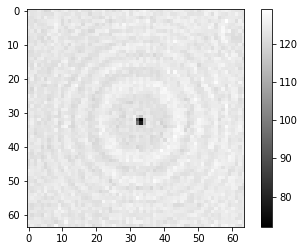

In [10]:
plt.imshow(test.update().resolve(), cmap="gray")
plt.colorbar()

In [11]:
training_set = dt.Value(crops[1][..., np.newaxis])
# For multiple crops
# import random
# training_set = dt.Value(lambda: random.choice(crops))

In [12]:
# For 2D training
TRAIN = False

if TRAIN:
    model = dt.models.LodeSTAR(input_shape=(None, None, 1))
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
    history = model.fit(
        training_set,
        epochs=50,
        batch_size=8,
    )
    model.model.model.save_weights("../models/2d-tracking-holo.h5")
else:
    model = dt.models.LodeSTAR(input_shape=(None, None, 1))
    model.model.load_weights("../models/2d-tracking-holo.h5")

Metal device set to: AMD Radeon Pro 5300M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



2022-07-28 19:18:02.740858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-28 19:18:02.741807: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-28 19:18:02.742038: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Generating 167 / 160 samples before starting training
Epoch 1/50


2022-07-28 19:18:11.708773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - 11s 37ms/step - total_loss: 15.8969 - consistency_loss: 2.6870
Epoch 2/50
167/167 [==============================] - 7s 40ms/step - total_loss: 3.9468 - consistency_loss: 2.4638
Epoch 3/50
167/167 [==============================] - 7s 42ms/step - total_loss: 3.9598 - consistency_loss: 2.3155
Epoch 4/50
167/167 [==============================] - 6s 36ms/step - total_loss: 3.9517 - consistency_loss: 2.4668
Epoch 5/50
167/167 [==============================] - 7s 43ms/step - total_loss: 3.6613 - consistency_loss: 2.1432
Epoch 6/50
167/167 [==============================] - 8s 51ms/step - total_loss: 3.4422 - consistency_loss: 1.8989
Epoch 7/50
167/167 [==============================] - 7s 43ms/step - total_loss: 3.4312 - consistency_loss: 1.6262
Epoch 8/50
167/167 [==============================] - 9s 51ms/step - total_loss: 2.9855 - consistency_loss: 1.1607
Epoch 9/50
167/167 [==============================] - 8s 49ms/step - total_loss: 2.8234 -

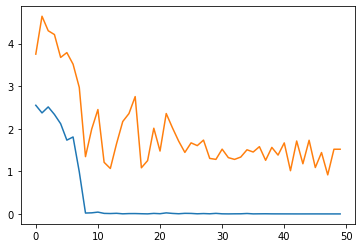

In [13]:
if TRAIN:
    plt.plot(history.history["consistency_loss"])
    plt.plot(history.history["total_loss"])

## Testing

In [23]:
p, w = model.predict(crop[np.newaxis, ..., np.newaxis])

1/1 [==============================] - 0s 263ms/step


2022-07-28 19:27:16.018242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


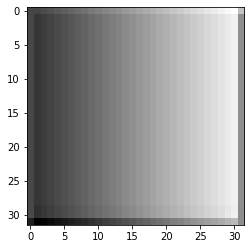

In [28]:
plt.imshow(p[0, ..., 1], cmap="gray")

In [19]:
frame2 = frame / np.median(frame)
alpha = 1
cutoff = 0.1
dets = model.predict_and_detect(frame2[np.newaxis, ..., np.newaxis], alpha=alpha, beta=alpha-1, cutoff=cutoff, mode="constant")

1/1 [==============================] - 0s 179ms/step


(-0.5, 1279.5, 1023.5, -0.5)

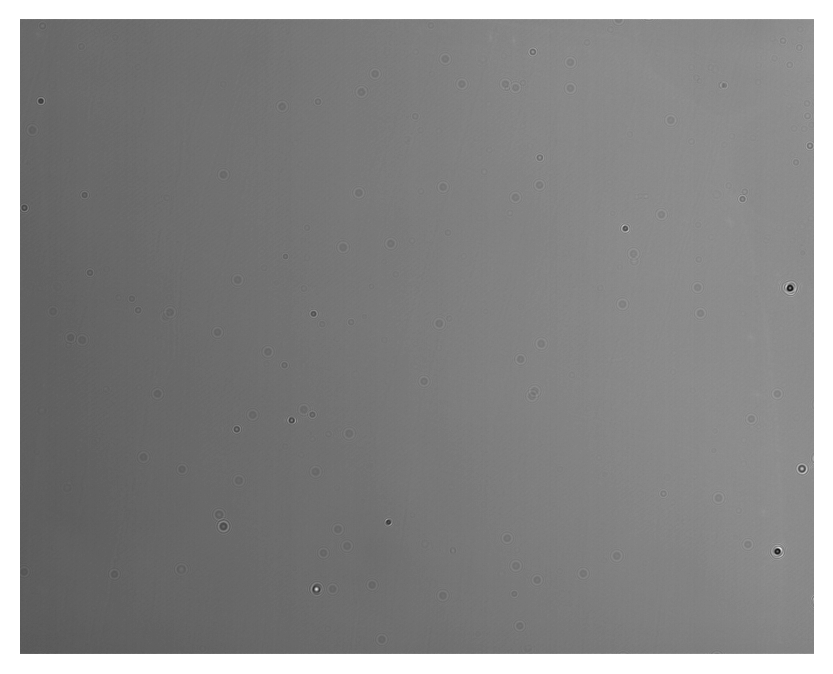

In [20]:
plt.figure(figsize=(frame.shape[0]/dpi, frame.shape[1]/dpi), dpi=dpi, frameon=False)
plt.imshow(frame, cmap="gray")
plt.scatter(dets[0][:, 1], dets[0][:, 0], s=100, facecolors="None", edgecolors="red", alpha=0.3)
# [plt.text(dets[0][:,1], dets[0][0:,0], str(i), color="orange", fontsize=6) for i in range(len(dets[0]))]
plt.axis("off")

In [91]:
# generator = dt.models.lodestar.LodeSTARGenerator(
#     training_set,
#     3, 
#     (group, equivariance), 
#     batch_size=8, 
#     min_data_size=200, 
#     max_data_size=400
# )

In [90]:
# with generator:
#     model = dt.models.LodeSTAR(input_shape=(None, None, 1), num_outputs=3)
#     model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
#     model.fit(generator, epochs=100, steps_per_epoch=100)


Generating 208 / 200 samples before starting training
Epoch 1/100


2022-07-27 17:36:54.146992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 6s 42ms/step - total_loss: 3.8152 - consistency_loss: 2.3181
Epoch 2/100
100/100 [==============================] - 4s 40ms/step - total_loss: 2.8105 - consistency_loss: 1.8948
Epoch 3/100
100/100 [==============================] - 4s 37ms/step - total_loss: 2.1763 - consistency_loss: 1.4352
Epoch 4/100
100/100 [==============================] - 4s 41ms/step - total_loss: 2.2684 - consistency_loss: 1.3533
Epoch 5/100
 28/100 [=======>......................] - ETA: 3s - total_loss: 2.1713 - consistency_loss: 1.4130

KeyboardInterrupt: 

In [268]:
# model.model.model.save_weights("ps-lodestar-3D.h5")

2022-07-27 17:47:25.760609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 442ms/step


IndexError: index 2 is out of bounds for axis 3 with size 2

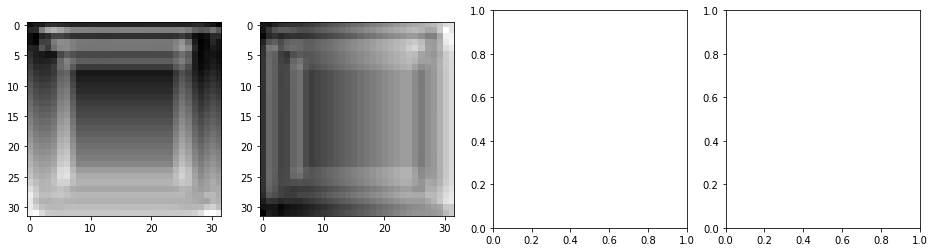

In [108]:
test_crop = crop[np.newaxis, ..., np.newaxis]
p, w = model.predict(test_crop)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
ax1.imshow(p[0, ..., 0], cmap="gray")
ax2.imshow(p[0, ..., 1], cmap="gray")
ax3.imshow(p[0, ..., 2], cmap="gray")
ax4.imshow(w[0, ..., 0], cmap="gray")

1/1 [==============================] - 0s 172ms/step


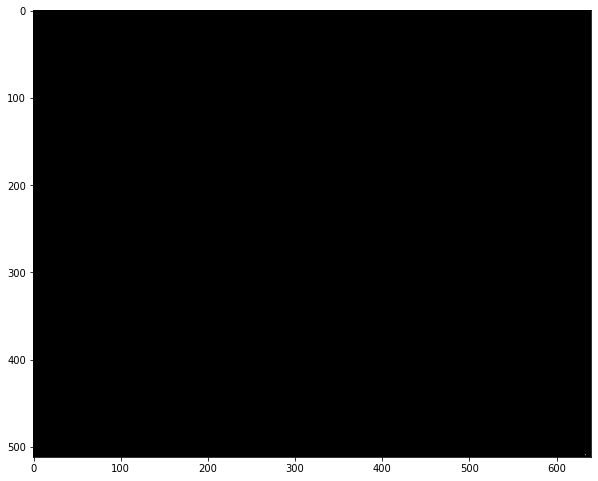

In [276]:
test_frame = frame[np.newaxis, ..., np.newaxis]
p, w = model.predict(test_frame)

plt.figure(figsize=(10, 10 ))
plt.imshow(w[0, ..., 0], cmap="gray")

1/1 [==============================] - 0s 174ms/step


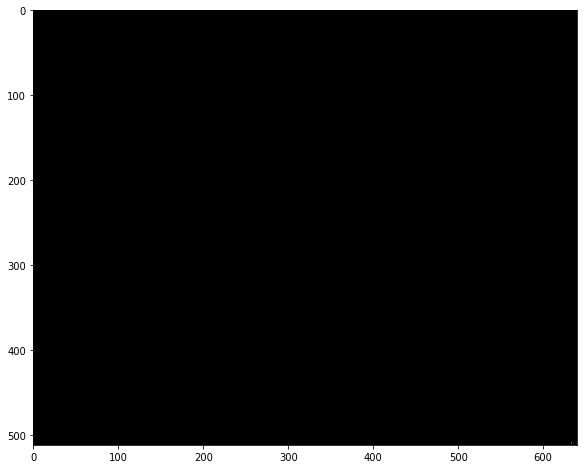

In [271]:
p, w = model.predict(frame2)
plt.figure(figsize=(12,8))
plt.imshow(w[0, ..., 0], cmap="gray")

(-0.5, 1279.5, 1023.5, -0.5)

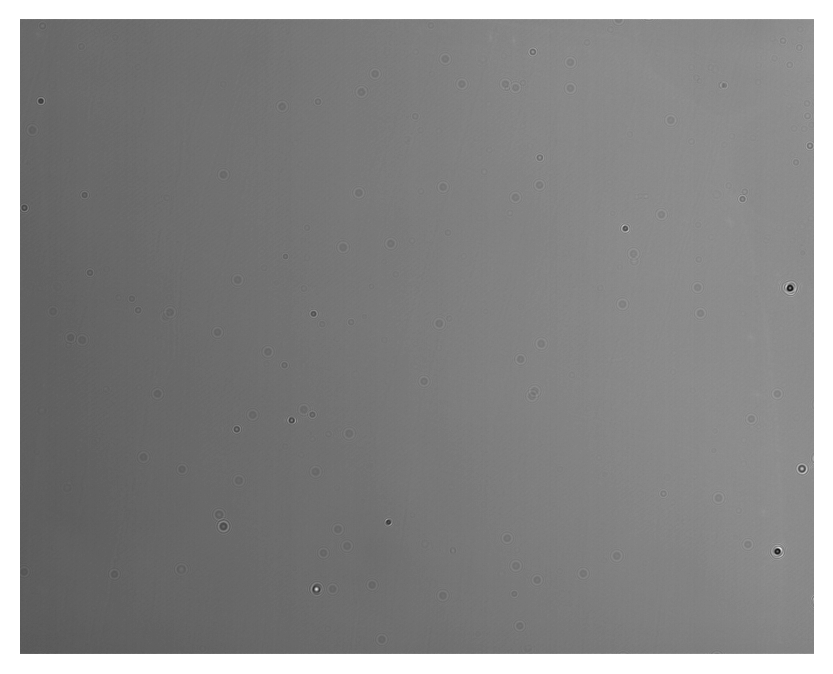

In [253]:
dpi=200
plt.figure(figsize=(frame.shape[0]/dpi, frame.shape[1]/dpi), dpi=dpi, frameon=False)
plt.scatter(dets[0][:, 1], dets[0][:, 0], s=200, facecolor="none", linewidths=3, edgecolors="g")
plt.imshow(frame, cmap="gray")
plt.axis("off")

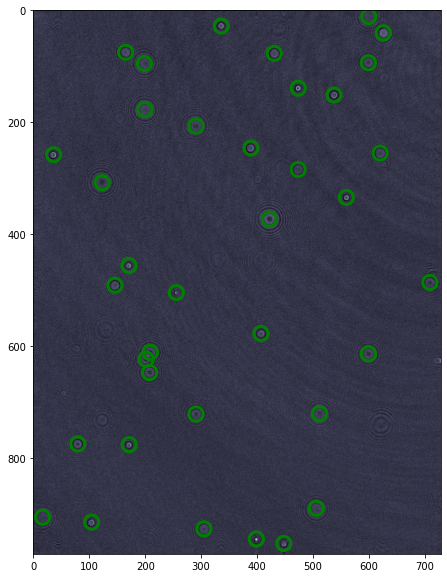

In [12]:

xvout = np.stack((np.real(vout), np.imag(vout)),axis=-1)
dets = model.predict_and_detect(xvout, alpha=0.9, beta=0.1, cutoff=0.1, mode="constant")

plt.figure(figsize=(10, 10))

plt.imshow(xvout[0, ..., 1], cmap="bone")
plt.scatter(dets[0][:, 1], dets[0][:, 0], s=200, facecolor="none", linewidths=3, edgecolors="g")
plt.show()


In [13]:

traces = []
for idx in range(len(dets)):

    connections = []
    connected_observations = []
    # Trace doroplets
    for idy, trace in enumerate(traces):

        last_frame, *pos = trace[-1]
        if idx - last_frame > 4:
            continue

        for idz, new_pos in enumerate(dets[idx]):
            distance = np.sqrt(np.square(new_pos[:2] - pos[:2]).sum())
            
            if (
                distance < 10 and idz not in connected_observations
            ):
                connected_observations.append(idz)
                trace.append(np.array((idx, *new_pos)))

    detections = [p for i, p in enumerate(dets[idx]) if i not in connected_observations]

    # Initiate new traces
    for det in detections:
        traces.append([np.array((idx, *det))])

# traces = list(filter(lambda t: len(t) > , traces))

len(traces)

611

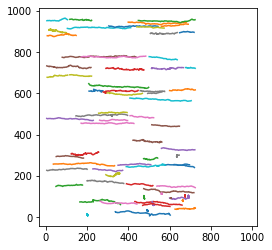

In [14]:
_traces = list(map(np.array, traces))
_traces = list(filter(lambda t: len(t) > 20, _traces))
for trace in _traces:
    plt.plot(trace[:, 2], trace[:, 1])
plt.axis("square")
plt.show()


<ipython-input-1-19f2b18317f8>:14: UserWarning: linewidths is ignored by contourf
  f = ax.contourf(X, Y, val, 100, offset=0.02, linewidths=0, vmin=-0.05, vmax=0.1)


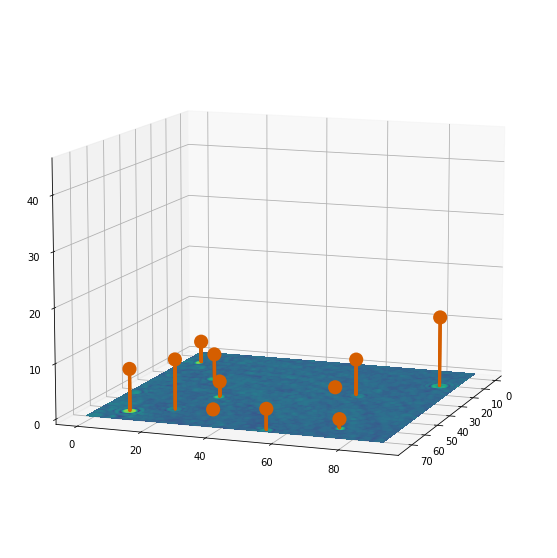

In [15]:
import seaborn
t = 30
val = dt.AveragePooling((1,1))(xvout[t, :400, 400:800, 1])
val = dt.GaussianBlur(2)(val)
# plt.set_cmap("bone")
val = np.array(val)

X, Y = np.meshgrid(np.arange(val.shape[1]) * 2 *0.114, np.arange(val.shape[0])* 2 *0.114)

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection="3d")

f = ax.contourf(X, Y, val, 100, offset=0.02, linewidths=0, vmin=-0.05, vmax=0.1)

for c in f.collections:
    c.set_edgecolor("none")

detections = np.array(detections)
_dets = dets[0][dets[0][:, 0] < 400]
for _dets in _traces:
    _dets = _dets[_dets[:, 0] < t]
    _dets = _dets[:, 1:]
    if not _dets.size or _dets[-1, 1] < 400 or _dets[-1, 1] > 800 or _dets[-1, 0] > 400:
        continue
    _dets[:, 0] = _dets[:, 0] * 2 * 0.114
    _dets[:, 1] = (_dets[:, 1] - 400) * 2 * 0.114
    _dets[:, 2] = _dets[:, 2] + 0
    
    d = _dets[-1]

    ax.scatter(_dets[-1, 1], _dets[-1, 0], np.abs(_dets[-1, 2]), alpha=1, s=200, edgecolors="none", facecolors=seaborn.color_palette("colorblind")[3])
    ax.scatter([d[1]]*100, [d[0]] * 100, np.linspace(np.abs(d[2]), 0.05, 100), color=seaborn.color_palette("colorblind")[3], marker=".", alpha=1)


ax.view_init(11, 20)
# plt.xticks([])
# plt.yticks([])
ax.set_zlim(0, 200* 2 *0.114)
plt.savefig("vertical_prediction.png", dpi=200, bbox_inches="tight")

In [16]:
completed_traces = holotraces["CompletedTraces"]

all_holo_traces = []

for i in range(completed_traces.shape[1]):

    trace = completed_traces[0, i]
    trace = np.array(trace[0][0][1])
    trace[:, 0] -= 203
    trace[:, 1:3] = trace[:, 1:3] / 0.114 / 2 + 2
    all_holo_traces.append(trace)

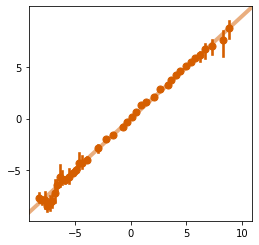

In [17]:
import scipy.spatial

z_pred = []
z_holo = []
for t in range(102):
    positions = []
    holo_pos = []
    for trace in _traces:
        x = trace[trace[:, 0] == t]
        if x.size:
            positions.append(x[0])

    for trace in all_holo_traces[:]:
        x = trace[trace[:, 0] == t]
        if x.size:
            holo_pos.append(x[0])

    positions = np.array(positions)
    holo_pos = np.array(holo_pos)
    dist = scipy.spatial.distance.cdist(positions[:, 1:3], holo_pos[:, 1:3])

    row, col = scipy.optimize.linear_sum_assignment(dist)


    costs = dist[row, col]
    mrow = row[costs < 5]
    mcol = col[costs < 5]


    for r, c in zip(mrow, mcol):
        z_pred.append(positions[r, 3])
        z_holo.append(holo_pos[c, 3])

z_pred_arr = np.array(z_pred)
z_holo_arr = np.array(z_holo)

z_pred_arr += np.mean(z_holo_arr) - np.mean(z_pred_arr)

plt.figure(figsize=(4, 4))
plt.gca().set_aspect(1 / plt.gca().get_data_ratio())
seaborn.regplot(x=z_holo_arr - 10, y=z_pred_arr - 10, ci=99, x_bins=40, truncate=False, color=seaborn.color_palette("colorblind")[3], x_ci=99, fit_reg=False)
plt.gca().set_aspect(1 / plt.gca().get_data_ratio())
plt.yticks([-5, 0, 5])
plt.axline((5, 5), (10, 10), c=seaborn.color_palette("colorblind")[3], alpha=.5, linewidth=4)
plt.savefig("z_truevsactual.svg")

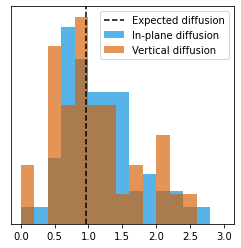

In [18]:
delta_time = all_holo_traces[0][1, 6] - all_holo_traces[0][0, 6]

def get_msd(x, max_dt=4):

    output = []
    for delt in range(max_dt):
        delta = x[1 + delt :] - x[: -(1 + delt)]
        
        th = 100 * np.sqrt(delt + 1)
        if np.any(delta > th):
            print(np.sum(delta > th))

        delta[delta > th] = 0
        squared_displacement = np.square(delta).sum(axis=-1)

        output.append(
            (
                np.mean(squared_displacement),
                np.std(squared_displacement),
                len(squared_displacement),
            )
        )

    return np.array(output)

def fit_to_line(msd):
    return np.polyfit(range(1, msd.shape[0]+1), msd[:, 0], 1)

msds = []
msds_z = []
for positions in _traces:
    positions = np.array(positions)
    positions[:, 2] -= np.arange(positions.shape[0]) * (positions[-1, 2] - positions[0, 2]) / positions.shape[0]
    
    msd = get_msd(positions[:, 1:3] * 0.114 * 2, 10) / 2
    a, b = fit_to_line(msd[:4])
    msds.append(a)

    msd = get_msd(positions[:, 3:4] * 1.5/1.33, 10)
    a, b = fit_to_line(msd[:4])
    msds_z.append(a)


plt.figure(figsize=(4, 4))
plt.hist(np.array(msds) / delta_time / 2, 15, range=(0, 3), density=True, alpha=1, facecolor=seaborn.color_palette("colorblind")[9])
plt.hist(np.array(msds_z) / delta_time / 2, 15, range=(0, 3), density=True, alpha=0.66, facecolor=seaborn.color_palette("colorblind")[3])

plt.yticks([])
plt.axvline(0.9638, c="k", linestyle="--")
plt.legend(["Expected diffusion", "In-plane diffusion", "Vertical diffusion", ])
plt.savefig("diffusion_histogram.svg")
